In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [2]:
data = pd.read_csv('measures_v2.csv')
data = data.drop(['profile_id'],axis = 1)

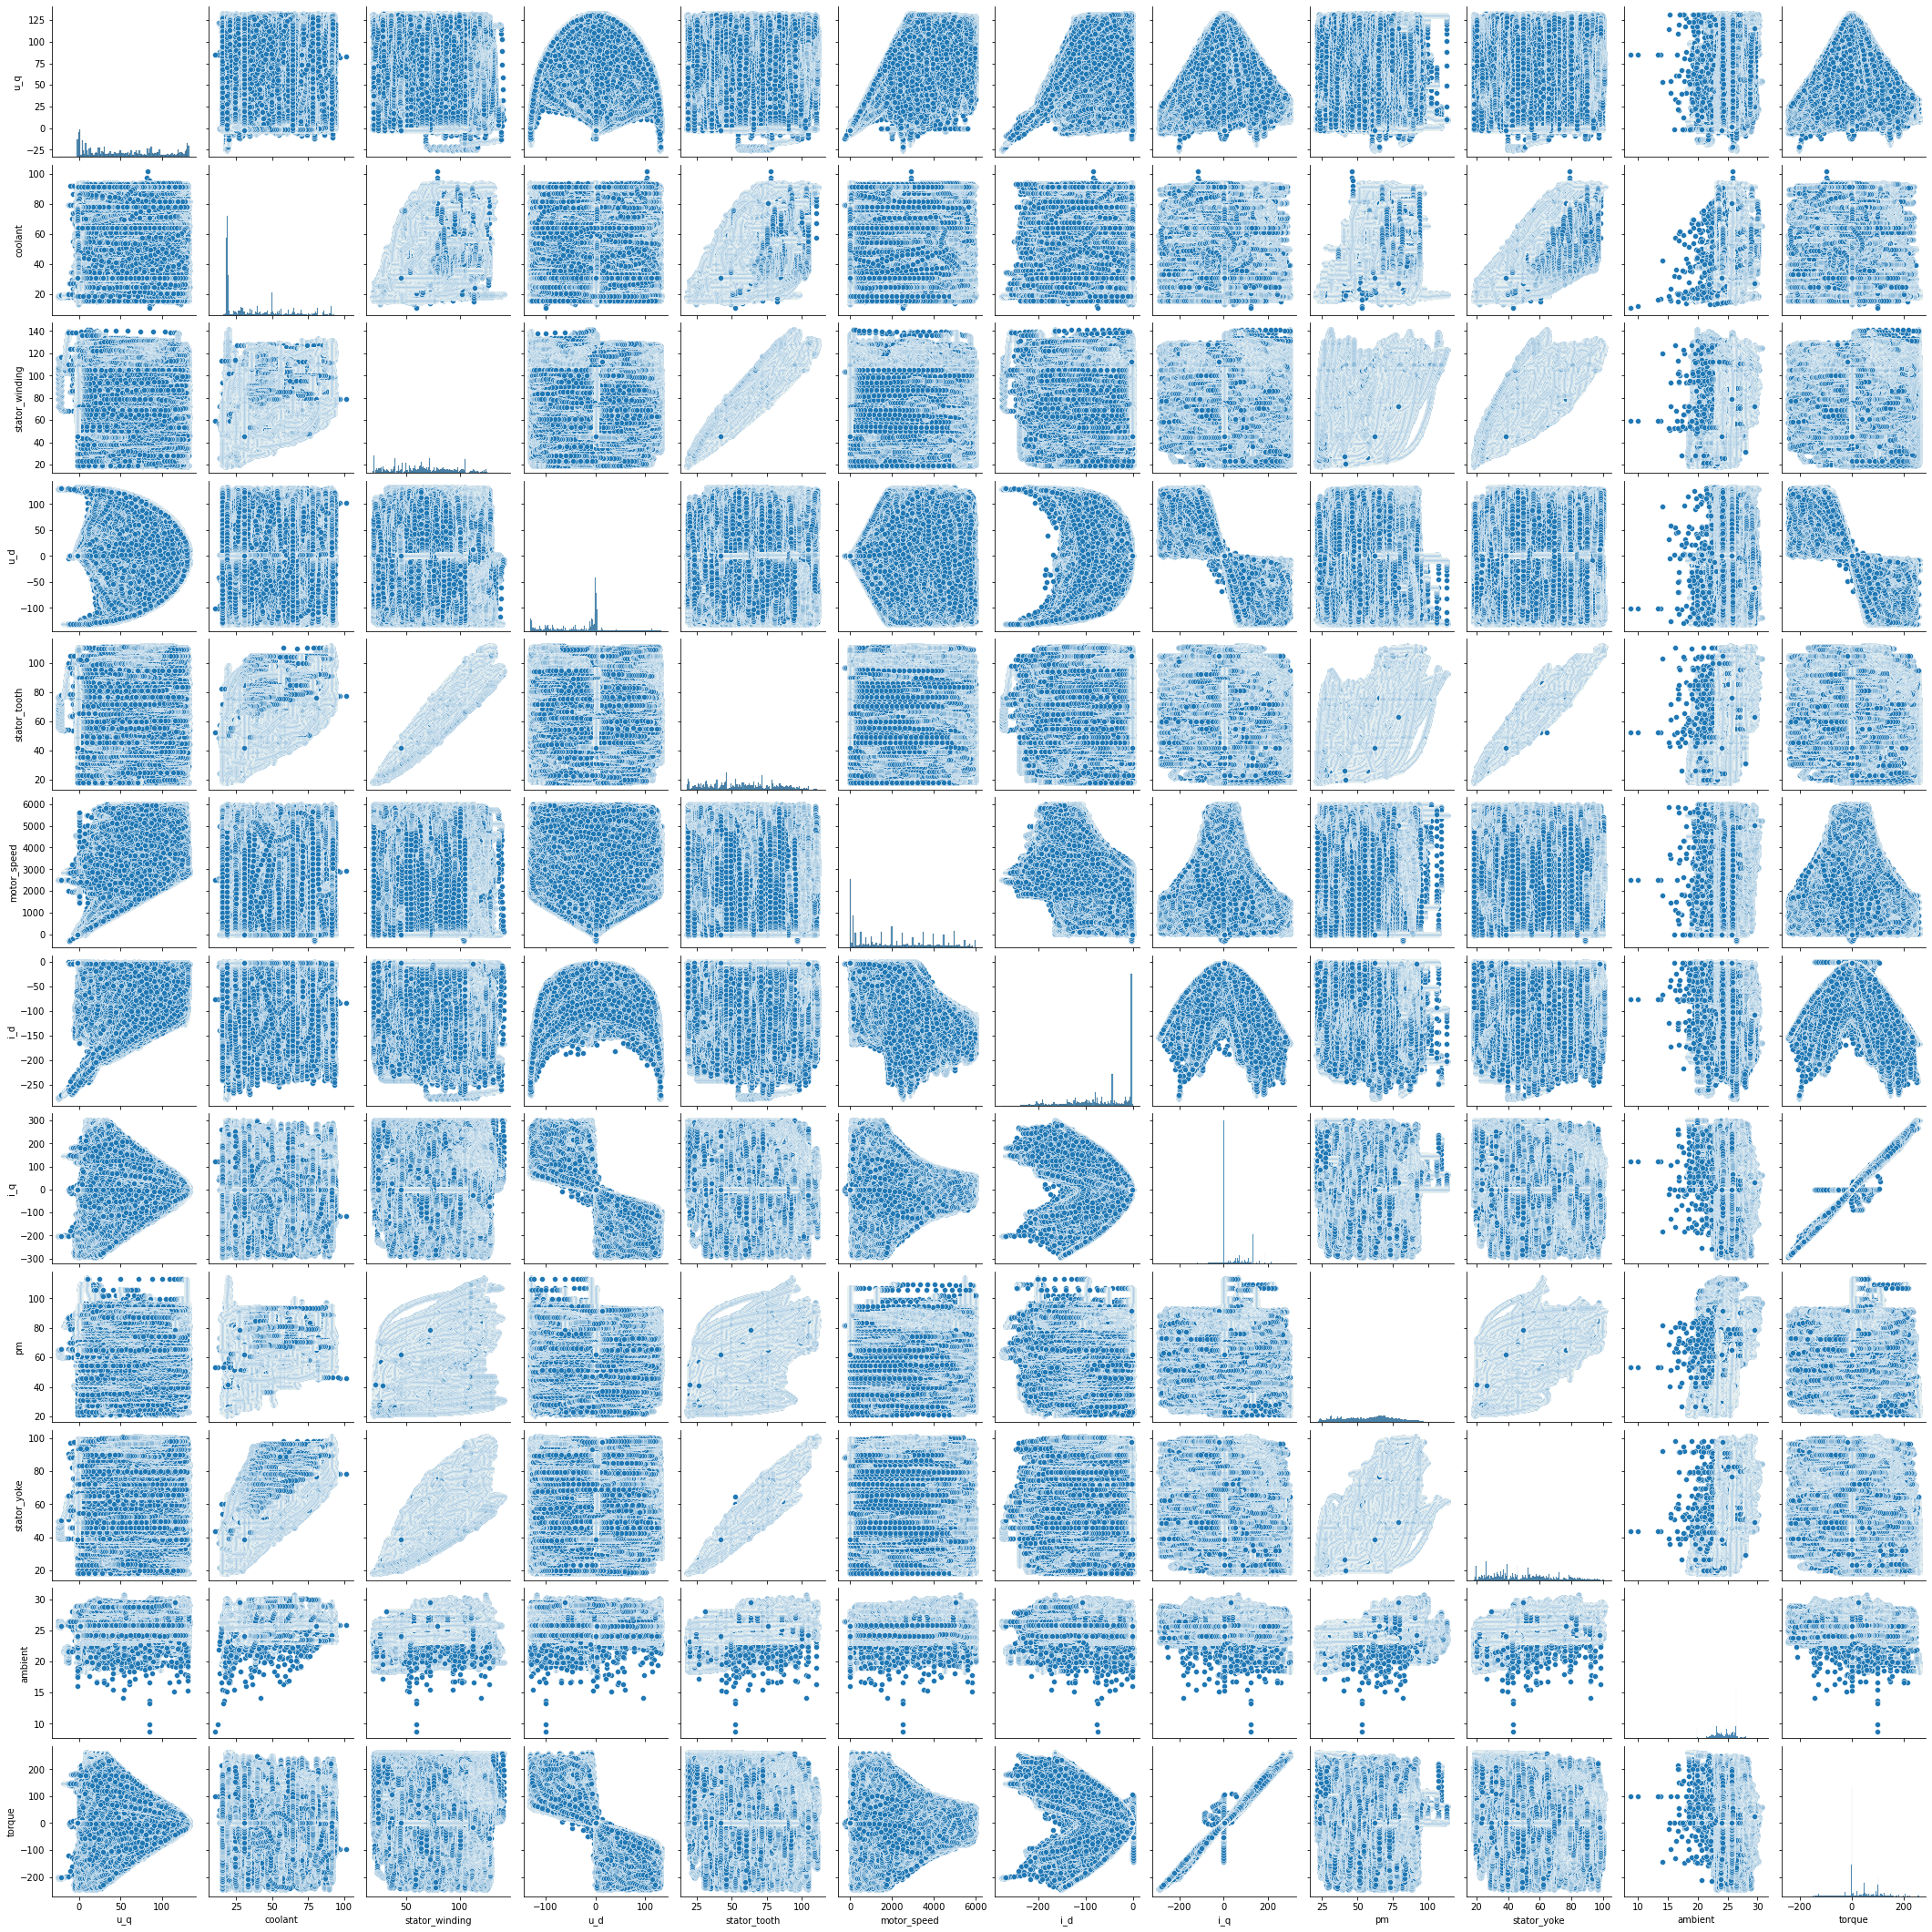

In [3]:
import seaborn as sns
sns.pairplot(data)

<AxesSubplot:>

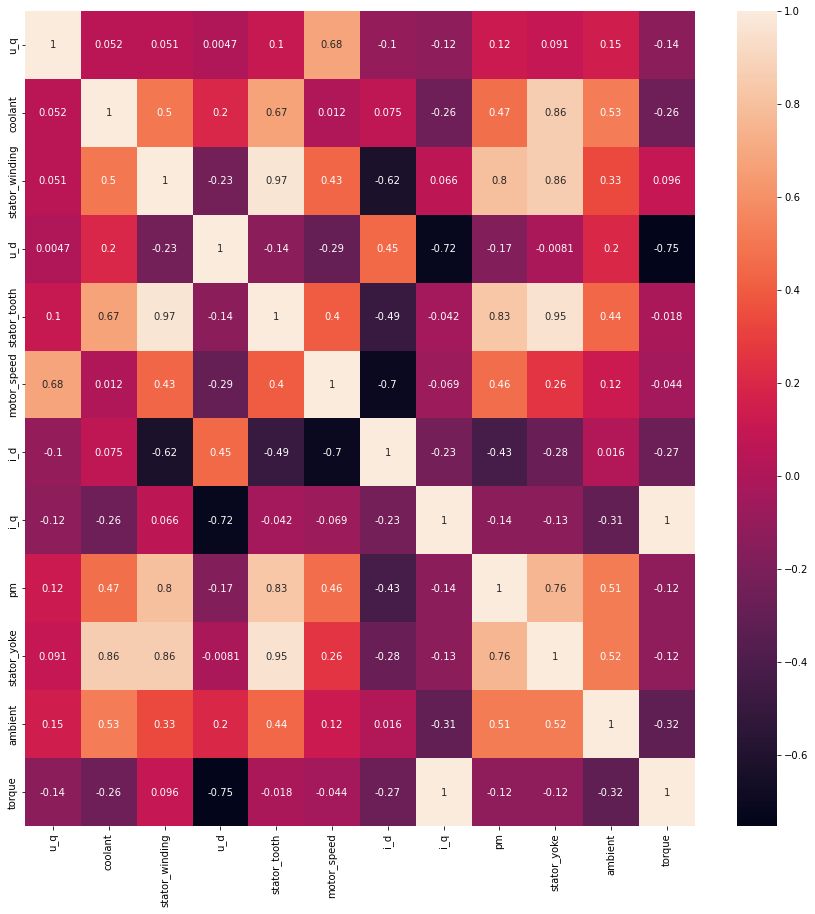

In [4]:
plt.figure(figsize = (15,15))
sns.heatmap(data.corr(), annot = True)

### Out of all 13 the motor_speed (rpm), pm(permanent magnet temp in celcius) & torque is the resulting quantities.
profile_id is the measurment session.

## Preparing dataset for temperature related quantities

In [5]:
data_temp = data.drop(['u_q','u_d','i_q','i_d','torque'],axis = 1)
pm = data_temp.drop(['pm'],axis = 1)
data_temp = pd.concat([pm,data_temp['pm']],axis = 1)
data_temp

coolant  stator_winding  stator_tooth  motor_speed  stator_yoke  \
0        18.805172       19.086670     18.293219     0.002866    18.316547   
1        18.818571       19.092390     18.294807     0.000257    18.314955   
2        18.828770       19.089380     18.294094     0.002355    18.326307   
3        18.835567       19.083031     18.292542     0.006105    18.330833   
4        18.857033       19.082525     18.291428     0.003133    18.326662   
...            ...             ...           ...          ...          ...   
1330811  30.721298       45.274497     41.934347     0.000380    38.653720   
1330812  30.721306       45.239017     41.868923     0.002985    38.656328   
1330813  30.721312       45.211576     41.804819     0.002301    38.650923   
1330814  30.721316       45.193508     41.762220     0.005662    38.655686   
1330815  30.721319       45.132307     41.734763     0.004395    38.660370   

           ambient         pm  
0        19.850691  24.554214  
1        19.850672  24.538078  
2        19.850657  24.544693  
3        19.850647  24.554018  
4        19.850639  24.565397  
...            ...        ...  
1330811  23.989078  62.147780  
1330812  23.970700  62.142646  
1330813  23.977234  62.138387  
1330814  24.001421  62.133422  
1330815  24.027522  62.131429  

[1330816 rows x 7 columns]

In [6]:
data_temp.describe().transpose()

count         mean          std         min         25%  \
coolant         1330816.0    36.229995    21.786149   10.623751   18.698135   
stator_winding  1330816.0    66.342745    28.672061   18.585815   42.787957   
stator_tooth    1330816.0    56.878582    22.952233   18.133976   38.416012   
motor_speed     1330816.0  2202.080728  1859.663350 -275.549144  317.110665   
stator_yoke     1330816.0    48.187965    19.991004   18.076689   31.990333   
ambient         1330816.0    24.565256     1.929522    8.783478   23.184804   
pm              1330816.0    58.506776    19.001498   20.856956   43.151582   

                        50%          75%          max  
coolant           26.900141    49.857487   101.598512  
stator_winding    65.110129    88.141137   141.362885  
stator_tooth      56.036345    75.586682   111.946423  
motor_speed     1999.976685  3760.639058  6000.015137  
stator_yoke       45.625509    61.460828   101.147964  
ambient           24.797327    26.217019    30.714205  
pm                60.266287    72.008371   113.606628

## Finding Spearman Correlation

In [7]:
para = [data_temp['coolant'], data_temp['stator_winding'], data_temp['stator_tooth'], data_temp['motor_speed'], data_temp['stator_yoke'], data_temp['ambient']]
name = data_temp.columns
for i in range(6) :
    from scipy.stats import spearmanr
    coef, p = spearmanr(data_temp['pm'], para[i])
    print('spearman correlation coefficient for pm and {} is: {}'.format(name[i], coef))
    alpha = 0.05
    if p > alpha:
        print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
    else:
        print('Samples are correlated (reject H0) p=%.3f' % p)

spearman correlation coefficient for pm and coolant is: 0.5488365584064121
Samples are correlated (reject H0) p=0.000
spearman correlation coefficient for pm and stator_winding is: 0.799372982685639
Samples are correlated (reject H0) p=0.000
spearman correlation coefficient for pm and stator_tooth is: 0.8386164614031131
Samples are correlated (reject H0) p=0.000
spearman correlation coefficient for pm and motor_speed is: 0.4049022132193757
Samples are correlated (reject H0) p=0.000
spearman correlation coefficient for pm and stator_yoke is: 0.7990970983550237
Samples are correlated (reject H0) p=0.000
spearman correlation coefficient for pm and ambient is: 0.535961319997748
Samples are correlated (reject H0) p=0.000


# Conclusion
The dependancy of permanent magnet temperature is maximum on stator_tooth and stator_winding temp that is 0.839 spearman corelation coeffiecient and minimum on ambient temp that is 0.539 spearman corelation coeffiecient

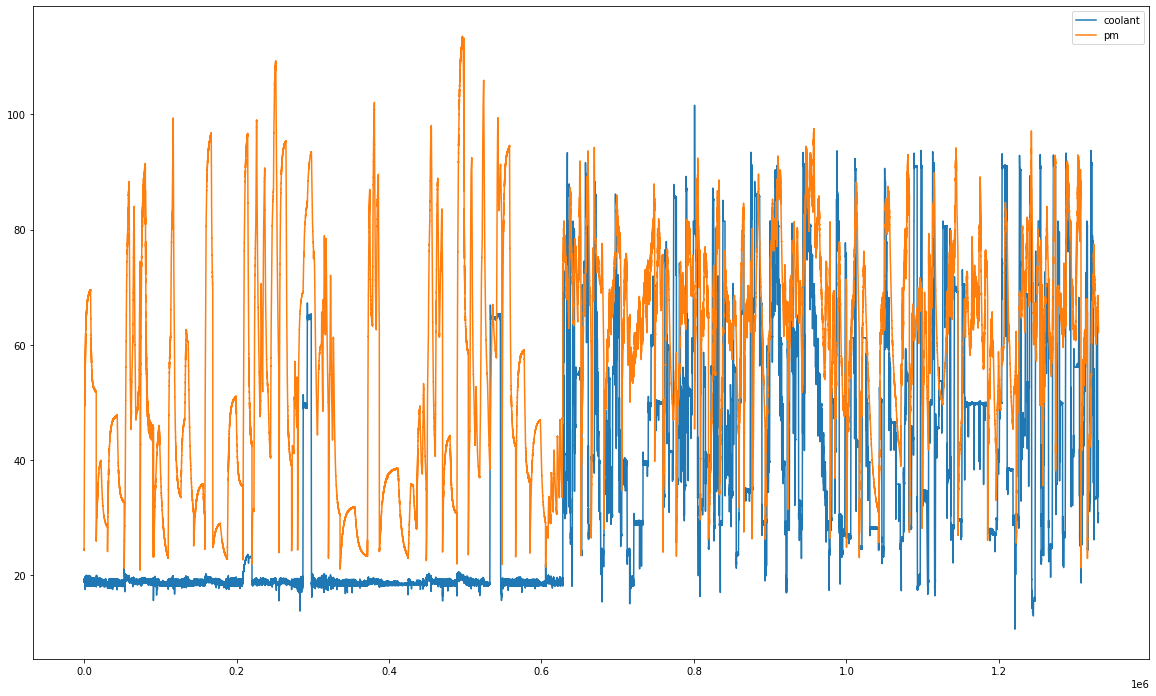

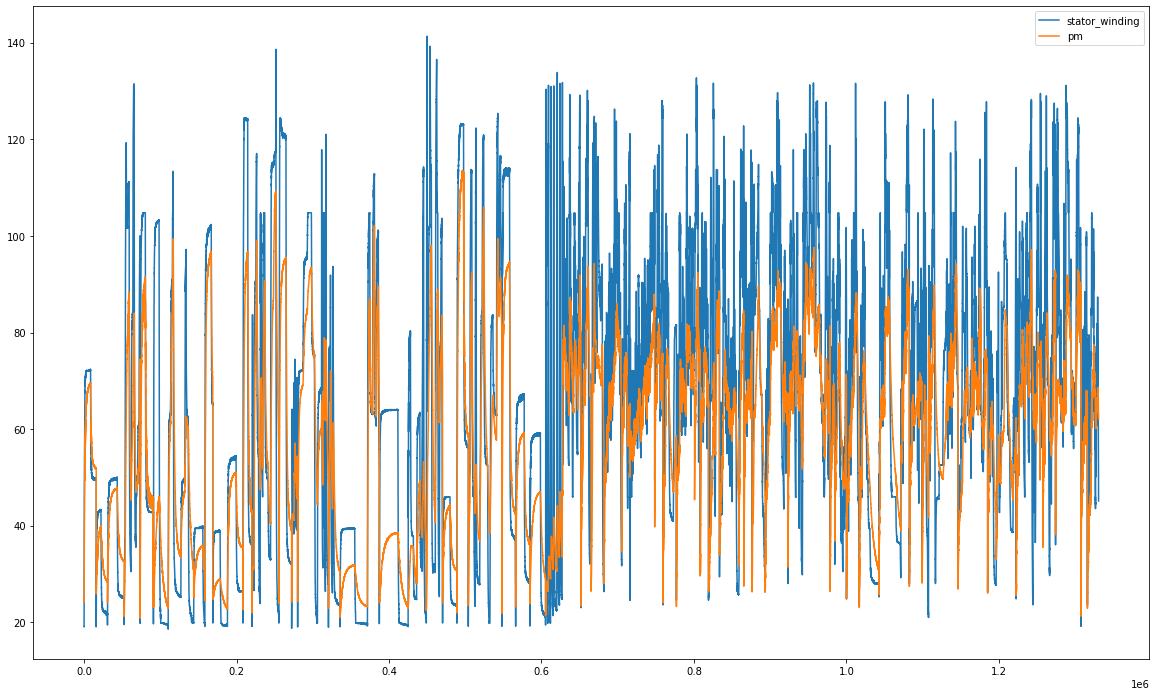

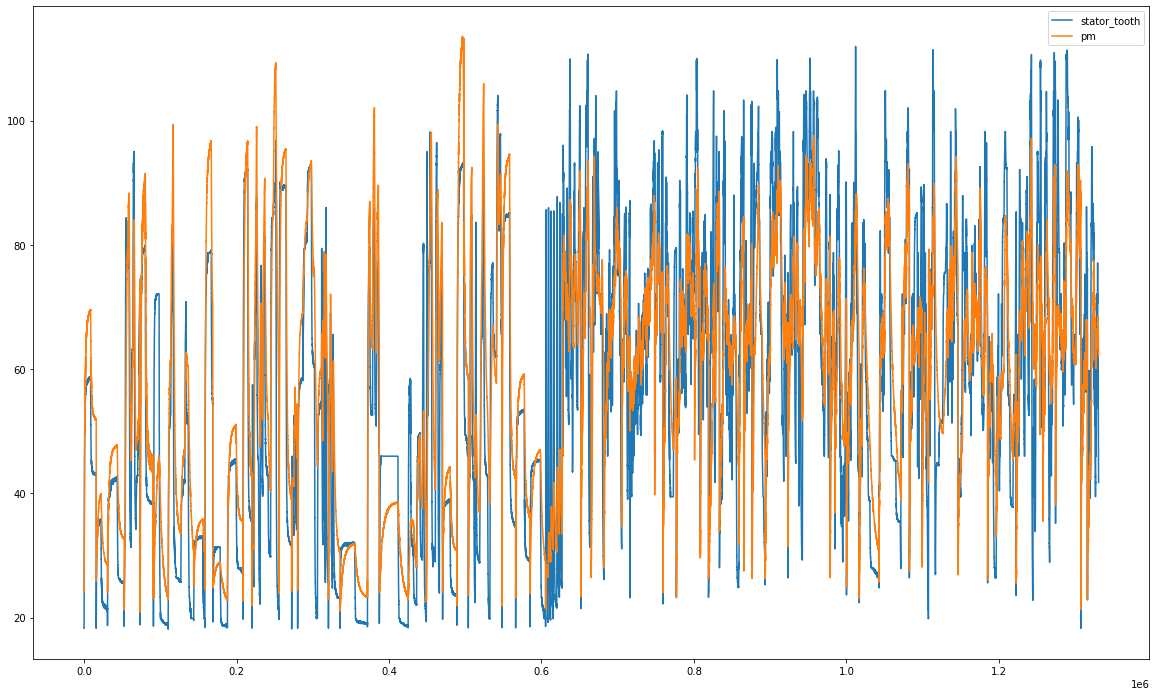

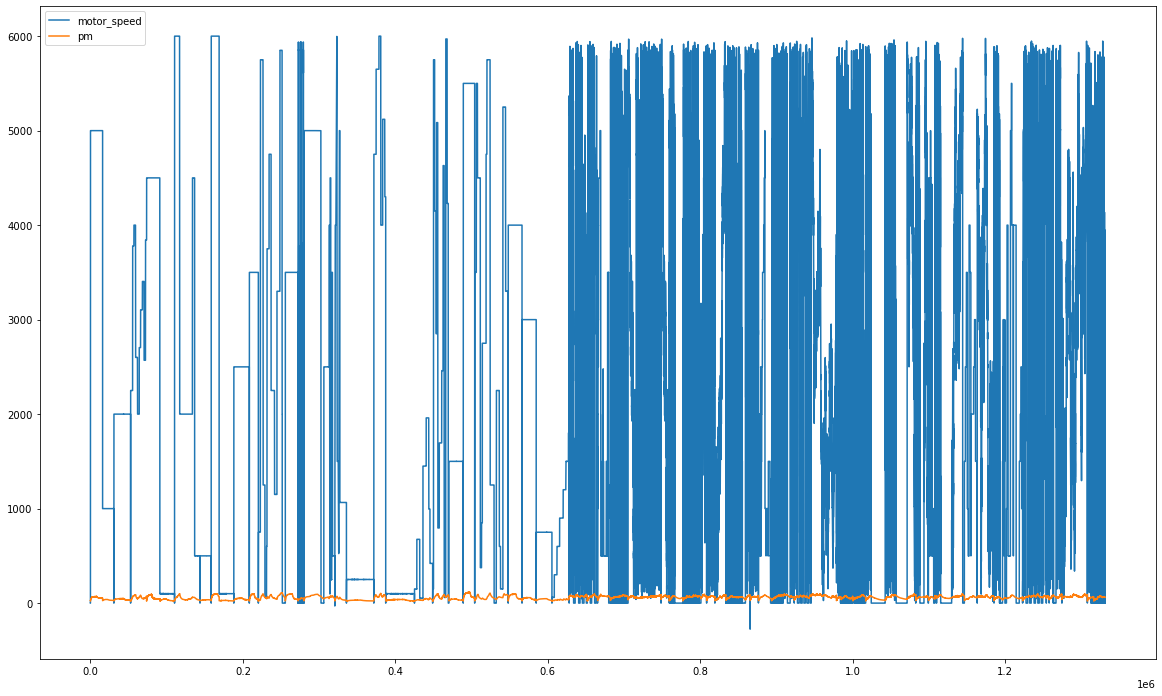

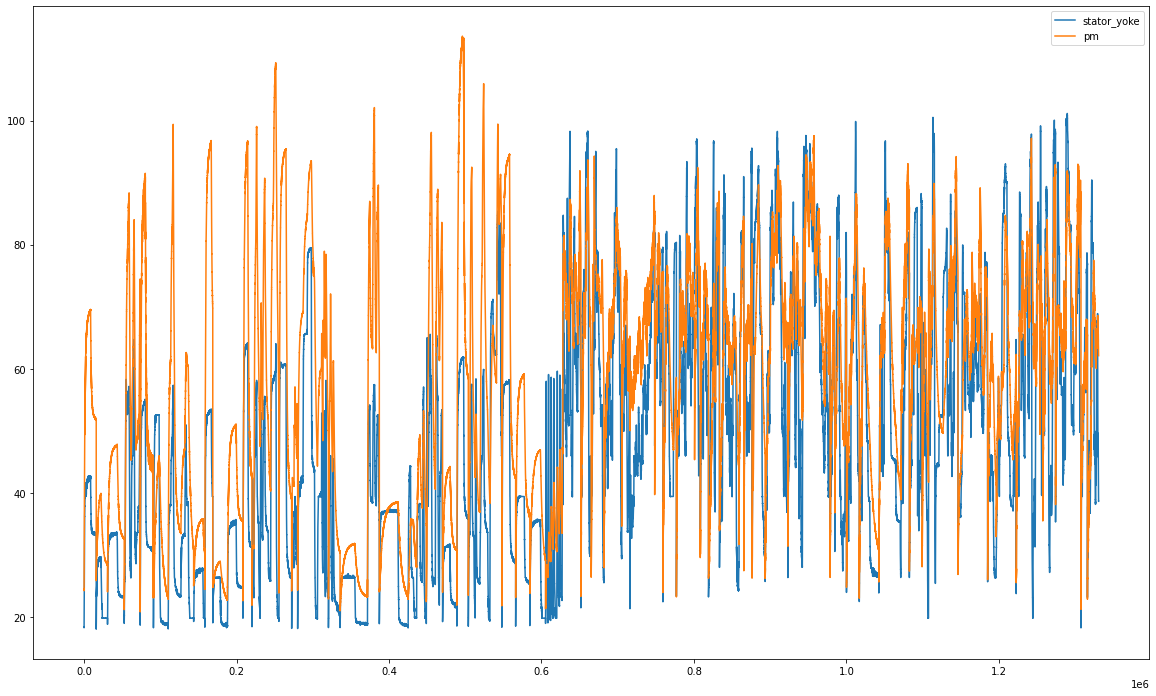

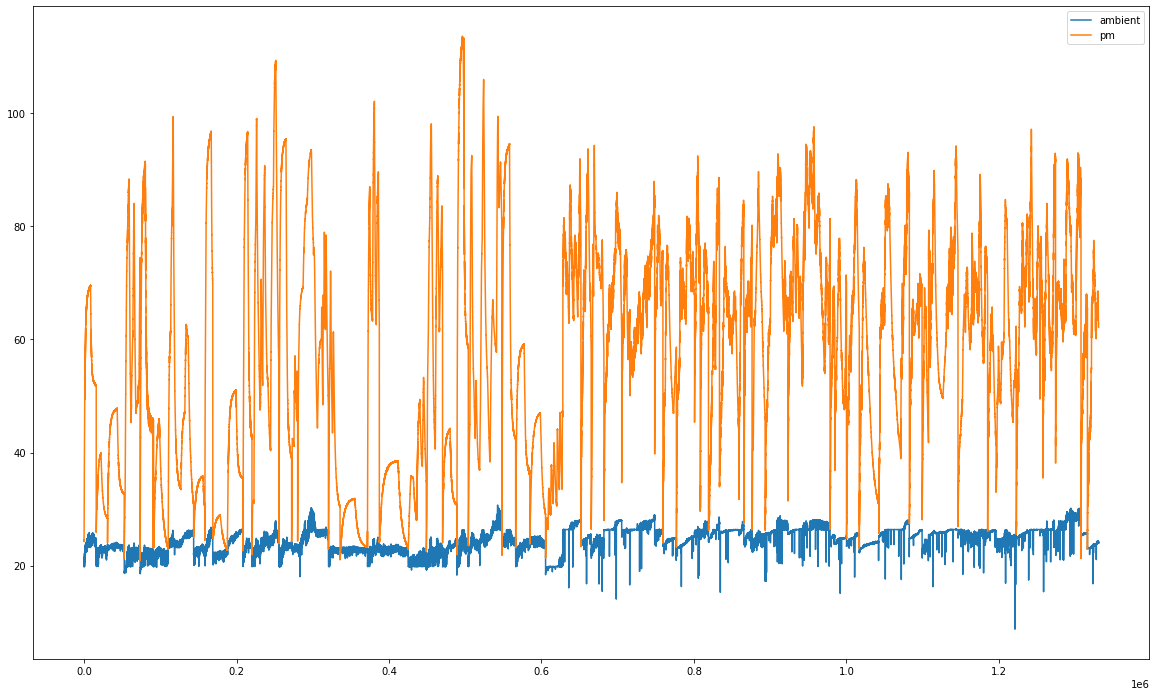

In [8]:
for i in range(6):
    data_temp[[name[i], 'pm']].plot(figsize = (20,12))

### Modeling and Preprocessing the data. The data is split in 2 frame (x,y) and (xt,yt). Whereas x,y is data in range of 0 to 1200000 further it is being used for modeling the algo. xt, yt consist of remaining datapoints, which act as compltely unseen data for prediction and testing.

In [9]:
x = data_temp.iloc[:1200000,:-1]
y = data_temp.iloc[:1200000,-1]

In [10]:
xt = data_temp.iloc[1200001:,:-1]
yt = data_temp.iloc[1200001:,-1]

In [11]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3)

## Linear Regression

In [12]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg = reg.fit(x_train,y_train)
y_pred = reg.predict(x_test)
linreg_r2 = r2_score(y_pred,y_test)

In [13]:
train_score_reg = reg.score(x_train, y_train)
test_score_reg = reg.score(x_test, y_test)
unseen_score_reg = reg.score(xt,yt)

print("The train score for reg model is {}".format(train_score_reg))
print("The test score for reg model is {}".format(test_score_reg))
print('The unseen data score for reg model is {}'.format(unseen_score_reg))

The train score for reg model is 0.8372021443445192
The test score for reg model is 0.8371693327938543
The unseen data score for reg model is 0.5488137957345832


In [40]:
yt_pred = reg.predict(xt)
linreg_r2_us = r2_score(yt_pred,yt)
linreg_r2_us

0.5965659684385569

## ridge and lasso

In [15]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso
ridgeReg = Ridge(alpha=200)
ridgeReg.fit(x_train,y_train)

train_score_ridge = ridgeReg.score(x_train, y_train)
test_score_ridge = ridgeReg.score(x_test, y_test)

print("\nRidge Model............................................\n")
print("The train score for ridge model is {}".format(train_score_ridge))
print("The test score for ridge model is {}".format(test_score_ridge))


Ridge Model............................................

The train score for ridge model is 0.8372021337301006
The test score for ridge model is 0.8371695090084084


In [41]:
y_pred = ridgeReg.predict(x_test)
rid_r2 = r2_score(y_pred,y_test)
rid_r2

0.8059549496765446

In [42]:
yt_pred = ridgeReg.predict(xt)
rid_r2_us = r2_score(yt_pred,yt)
rid_r2_us

0.5965992332419714

In [18]:
lasso = Lasso(alpha = 10)
lasso.fit(x_train,y_train)
train_score_ls =lasso.score(x_train,y_train)
test_score_ls =lasso.score(x_test,y_test)

print("The train score for ls model is {}".format(train_score_ls))
print("The test score for ls model is {}".format(test_score_ls))

The train score for ls model is 0.7234081004781133
The test score for ls model is 0.7226583883360365


In [43]:
y_pred = lasso.predict(x_test)
lasso_r2 = r2_score(y_pred,y_test)
lasso_r2

0.5974643572622843

In [44]:
yt_pred = lasso.predict(xt)
lasso_r2_us = r2_score(yt_pred,yt)
lasso_r2_us

0.4349524930672345

## XGBR

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from numpy import absolute

XGBR = XGBRegressor(n_estimators=50, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
score = cross_val_score(XGBR, x, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = absolute(score)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 2.778 (0.019)


In [23]:
XGBR.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=50, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0, ...)

In [45]:
y_pred = XGBR.predict (x_test)
xgbr_r2 = r2_score(y_pred, y_test)
xgbr_r2

0.950971349068737

In [46]:
yt_pred = XGBR.predict(xt)
xgbr_r2_us = r2_score(yt_pred, yt)
xgbr_r2_us

0.6285815312127276

## Support Vector Machine

In [26]:
from sklearn.svm import SVR
import numpy as np
svr = SVR()

In [27]:
xs = data_temp.iloc[:150000,:-1]
ys = data_temp.iloc[:150000,-1]

In [28]:
xs_train, xs_test, ys_train, ys_test = train_test_split(xs,ys, test_size = 0.2, random_state = 42)

In [29]:
ys_train = np.ravel(ys_train, order = 'C')
svr.fit(xs_train, ys_train)

SVR()

In [47]:
ys_pred = svr.predict(xs_test)
svm_r2 = r2_score(ys_pred, ys_test)
svm_r2

0.6052755907804893

In [32]:
xst = data_temp.iloc[150000:205000,:-1]
yst = data_temp.iloc[150000:205000,-1]
yst = np.ravel(yst)

In [48]:
yst_pred = svr.predict(xst)
svm_r2_us = r2_score(yst_pred,yst)
svm_r2_us

0.49184303824714626

## Random Forest Regressor

In [34]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators = 150, random_state = 42)

In [35]:
y_train = np.ravel(y_train)
rfr.fit(x_train,y_train)
y_pred = rfr.predict(x_test)

In [49]:
rfr_r2 = r2_score(y_pred, y_test)
rfr_r2

0.950971349068737

In [37]:
xt = data_temp.iloc[1200000:,:-1]
yt = data_temp.iloc[1200000:,-1]

In [51]:
yt_pred = rfr.predict(xt)
rfr_r2_us = r2_score(yt_pred, yt)
rfr_r2_us

0.5545030832318741

In [72]:
result = [['Linear regression', linreg_r2, linreg_r2_us], ['Ridge regression', rid_r2, rid_r2_us], ['Lasso regression' , lasso_r2, lasso_r2_us],['XGB regression',xgbr_r2, xgbr_r2_us],['SVM regression', svm_r2,svm_r2_us],['Random Forest',rfr_r2,rfr_r2_us]]
for i in range(len(result)):
    print('The r2_score of {} is : {} and of the unseen data is : {}'.format(result[i][0], result[i][1], result[i][2]))
    print('........................................................................ the deviation between r2_score is {}'.format(result[i][1] - result[i][2]))

The r2_score of Linear regression is : 0.8059663194288189 and of the unseen data is : 0.5965659684385569
........................................................................ the deviation between r2_score is 0.209400350990262
The r2_score of Ridge regression is : 0.8059549496765446 and of the unseen data is : 0.5965992332419714
........................................................................ the deviation between r2_score is 0.20935571643457318
The r2_score of Lasso regression is : 0.5974643572622843 and of the unseen data is : 0.4349524930672345
........................................................................ the deviation between r2_score is 0.16251186419504982
The r2_score of XGB regression is : 0.950971349068737 and of the unseen data is : 0.6285815312127276
........................................................................ the deviation between r2_score is 0.3223898178560094
The r2_score of SVM regression is : 0.6052755907804893 and of the unseen data is 

# The mininmum deviation is in SVM but considerable result can be of linear regression.